# Tutorial-1: Integrating RNA+ADT Single-Cell Data Using MIDAS
In this tutorial, we illustrate the process of integrating multi-modal single-cell data using MIDAS across various batches. To begin quickly, we will utilize data from the first three batches of the "WNN" datasets. We will manually construct a combined mosaic of modalities for integration.

## Data Downloading & Pre-processing
We offer pre-processed data that you can download from https://drive.google.com/drive/folders/1j3hDl2p4v3s0r5a-ktfHqbIhHbIPpUbS?usp=drive_link to save time. Meanwhile, labels are provided as well. However, if processing from raw data is preferred, follow these steps:

Download Data: Fetch the data from the provided link (https://atlas.fredhutch.org/nygc/multimodal-pbmc/).

Organize Data: Place the downloaded data into the directory as ./data/raw/rna+adt/multi.h5seurat.

Automate Processing: Run scripts to process the data, which typically involves loading it into a suitable data structure or format for further analysis.

In [1]:
# # for offline integration
# Rscript preprocess/rna+adt_wnn.R
# Rscript preprocess/combine_subsets.R --task wnn_demo 
# python preprocess/split_mat.py --task wnn_demo

## Integrating with MIDAS

In [2]:
from scmidas.models import MIDAS
from scmidas.datasets import GetDataInfo
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

### Initializing Model
We manually set "mods" to define a combination of modalities. If "mods" is not specified, all available modalities will be used for training.

In [3]:
task = "wnn_demo"
mods = {"subset_0":["rna", "adt"], "subset_1":["rna"], "subset_2":["adt"]}
data = [GetDataInfo(f'./data/processed/{task}', mods=mods)]  # Support integration of multiple GetDataInfo objects with different features.

3 subset(s) in this path {'rna': 4054, 'adt': 224}
  subset_0 :  6378 cells ; ['rna', 'adt']
  subset_1 :  5899 cells ; ['rna']
  subset_2 :  4628 cells ; ['adt']


### Training
The function .init_model can accept parameters for customizing the model structure. Here, we utilize the default model structure.

In [4]:
model = MIDAS(data)
model.init_model()
model.train(n_epoch=500, save_path=f'./result/{task}/train/')

  0%|          | 0/500 [00:00<?, ?it/s]

Parameter number: 9.092 M
Training ...


Loss: 1389.0552: 100%|██████████| 500/500 [1:21:14<00:00,  9.75s/it]


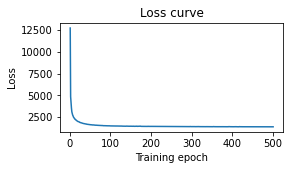

In [5]:
model.viz_loss()

### Inference
We support predicting various types of outputs, including embeddings and corrected counts. Here, we demonstrate how to retrieve embeddings.

In [6]:
model.predict(save_dir=f'./result/{task}/predict/')

  0%|          | 0/25 [00:00<?, ?it/s]

Predicting ...
Processing subset 0: ['rna', 'adt']


  0%|          | 0/24 [00:00<?, ?it/s]

Processing subset 1: ['rna']


  0%|          | 0/19 [00:00<?, ?it/s]

Processing subset 2: ['adt']


100%|██████████| 19/19 [00:04<00:00,  4.45it/s]


In [7]:
emb = model.read_preds()

  0%|          | 0/24 [00:00<?, ?it/s]

Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 1: z, joint


100%|██████████| 19/19 [00:00<00:00, 268.02it/s]


Loading subset 2: z, joint
Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint


## Visualization

/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


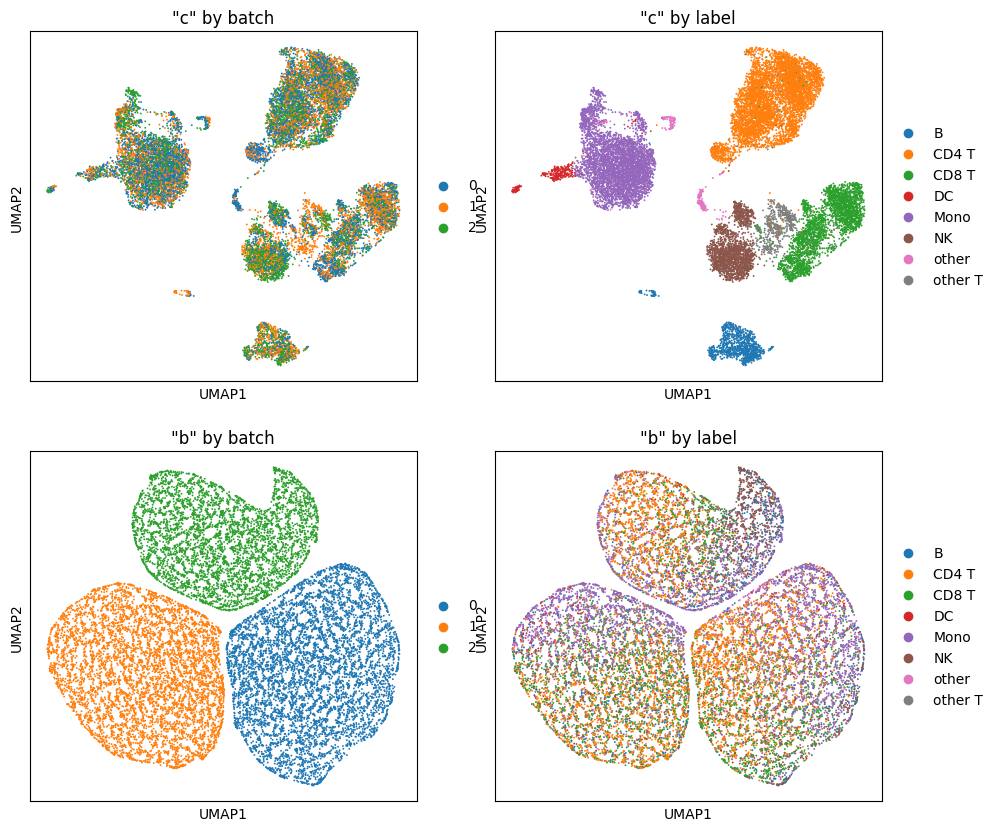

In [8]:
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata2 = sc.AnnData(b)
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata2.obs['batch'] = emb["s"]["joint"].astype('str')

label = pd.concat([pd.read_csv(f'./data/raw/rna+adt/wnn/p1_0/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/rna+adt/wnn/p2_0/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/rna+adt/wnn/p3_0/label_seurat/l1.csv', index_col=0),
                   ])
adata.obs['label'] = label.values.flatten()
adata2.obs['label'] = label.values.flatten()
sc.pp.subsample(adata, fraction=1)
sc.pp.subsample(adata2, fraction=1)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
f, ax = plt.subplots(2,2,figsize=[11, 10])
sc.pl.umap(adata, color='batch', title='"c" by batch', ax=ax[0, 0], show=False)
sc.pl.umap(adata, color='label', title='"c" by label', ax=ax[0, 1], show=False)
sc.pl.umap(adata2, color='batch', title='"b" by batch' , ax=ax[1, 0], show=False)
sc.pl.umap(adata2, color='label', title='"b" by label' , ax=ax[1, 1], show=False)
plt.show()